# COMS 4995 AML HW3

Huazhang Liu  
UNI: HL3338

Jianfeng Zhuang  
UNI: JZ3172

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import randint

In [313]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.woe import WOEEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [4]:
from catboost import CatBoostRegressor

In [5]:
from sklearn.model_selection import cross_val_score

In [6]:
pd.options.display.max_columns = 100

In [7]:
data = pd.read_csv("vehicles.csv")

In [8]:
data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,clean,manual,WVWPF7AJ6CW316713,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,1FTMF1EP3GKF13544,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,clean,automatic,3GTU2WEC6FG228025,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,1FTEX1EF6GKD25447,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,clean,automatic,1FT8W4DT8GEA90427,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


In [9]:
columns = np.array(data.columns)
print(columns)

['id' 'url' 'region' 'region_url' 'price' 'year' 'manufacturer' 'model'
 'condition' 'cylinders' 'fuel' 'odometer' 'title_status' 'transmission'
 'vin' 'drive' 'size' 'type' 'paint_color' 'image_url' 'description'
 'county' 'state' 'lat' 'long']


## Task 1: Identify Features

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            509577 non-null  int64  
 1   url           509577 non-null  object 
 2   region        509577 non-null  object 
 3   region_url    509577 non-null  object 
 4   price         509577 non-null  int64  
 5   year          508050 non-null  float64
 6   manufacturer  486813 non-null  object 
 7   model         501588 non-null  object 
 8   condition     277643 non-null  object 
 9   cylinders     309894 non-null  object 
 10  fuel          505592 non-null  object 
 11  odometer      417253 non-null  float64
 12  title_status  506515 non-null  object 
 13  transmission  505858 non-null  object 
 14  vin           302152 non-null  object 
 15  drive         365434 non-null  object 
 16  size          167574 non-null  object 
 17  type          368046 non-null  object 
 18  pain

#### When we are looking at the basic data information, we know that the "county" column is meaningless, because it is completely missing. So we choose to drop this column.

In [11]:
new_data = data.drop("county", axis = 1)

### Price 
#### Since the raw data have a lot of observations have prices clustering around 0, and some outliers have very large value of price, we choose to remove observations that have prices less than 5, then calculate IQR and remove all the outliers.

In [12]:
new_data = new_data.loc[data['price'] > 5,]
price_Q1 = new_data['price'].quantile(0.25)
price_Q3 = new_data['price'].quantile(0.75)
price_IQR = price_Q3 - price_Q1
new_data = new_data.loc[(new_data['price'] > price_Q1 - 1.5 * price_IQR) & (new_data['price'] < price_Q3 + 1.5 * price_IQR)]

#### The remaining observations' prices look more meaningful.

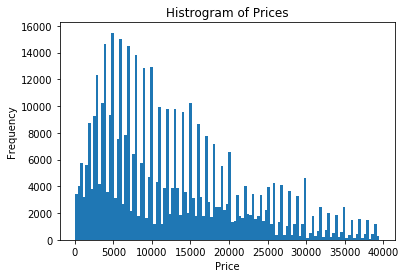

In [13]:
plt.hist(new_data['price'], bins = "auto")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histrogram of Prices")
plt.show()

In [14]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447819 entries, 0 to 509576
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            447819 non-null  int64  
 1   url           447819 non-null  object 
 2   region        447819 non-null  object 
 3   region_url    447819 non-null  object 
 4   price         447819 non-null  int64  
 5   year          446807 non-null  float64
 6   manufacturer  429318 non-null  object 
 7   model         441020 non-null  object 
 8   condition     254622 non-null  object 
 9   cylinders     275981 non-null  object 
 10  fuel          444445 non-null  object 
 11  odometer      367986 non-null  float64
 12  title_status  445127 non-null  object 
 13  transmission  444769 non-null  object 
 14  vin           258832 non-null  object 
 15  drive         321058 non-null  object 
 16  size          150617 non-null  object 
 17  type          322966 non-null  object 
 18  pain

### ID 
#### There are total of 447,819 non-null observations, while there are 447819 unique ID's. This means that if we include ID in our models, it is going to leak the information.

In [15]:
np.unique(new_data['id']).shape

(447819,)

In [16]:
new_data = new_data.drop('id', axis=1)

### URL
#### Same thing happens on the column "url"

In [17]:
np.unique(new_data['url']).shape

(447819,)

In [18]:
new_data = new_data.drop('url', axis=1)

### Region 
#### The column "region" can be left as a categorical feature for the model.

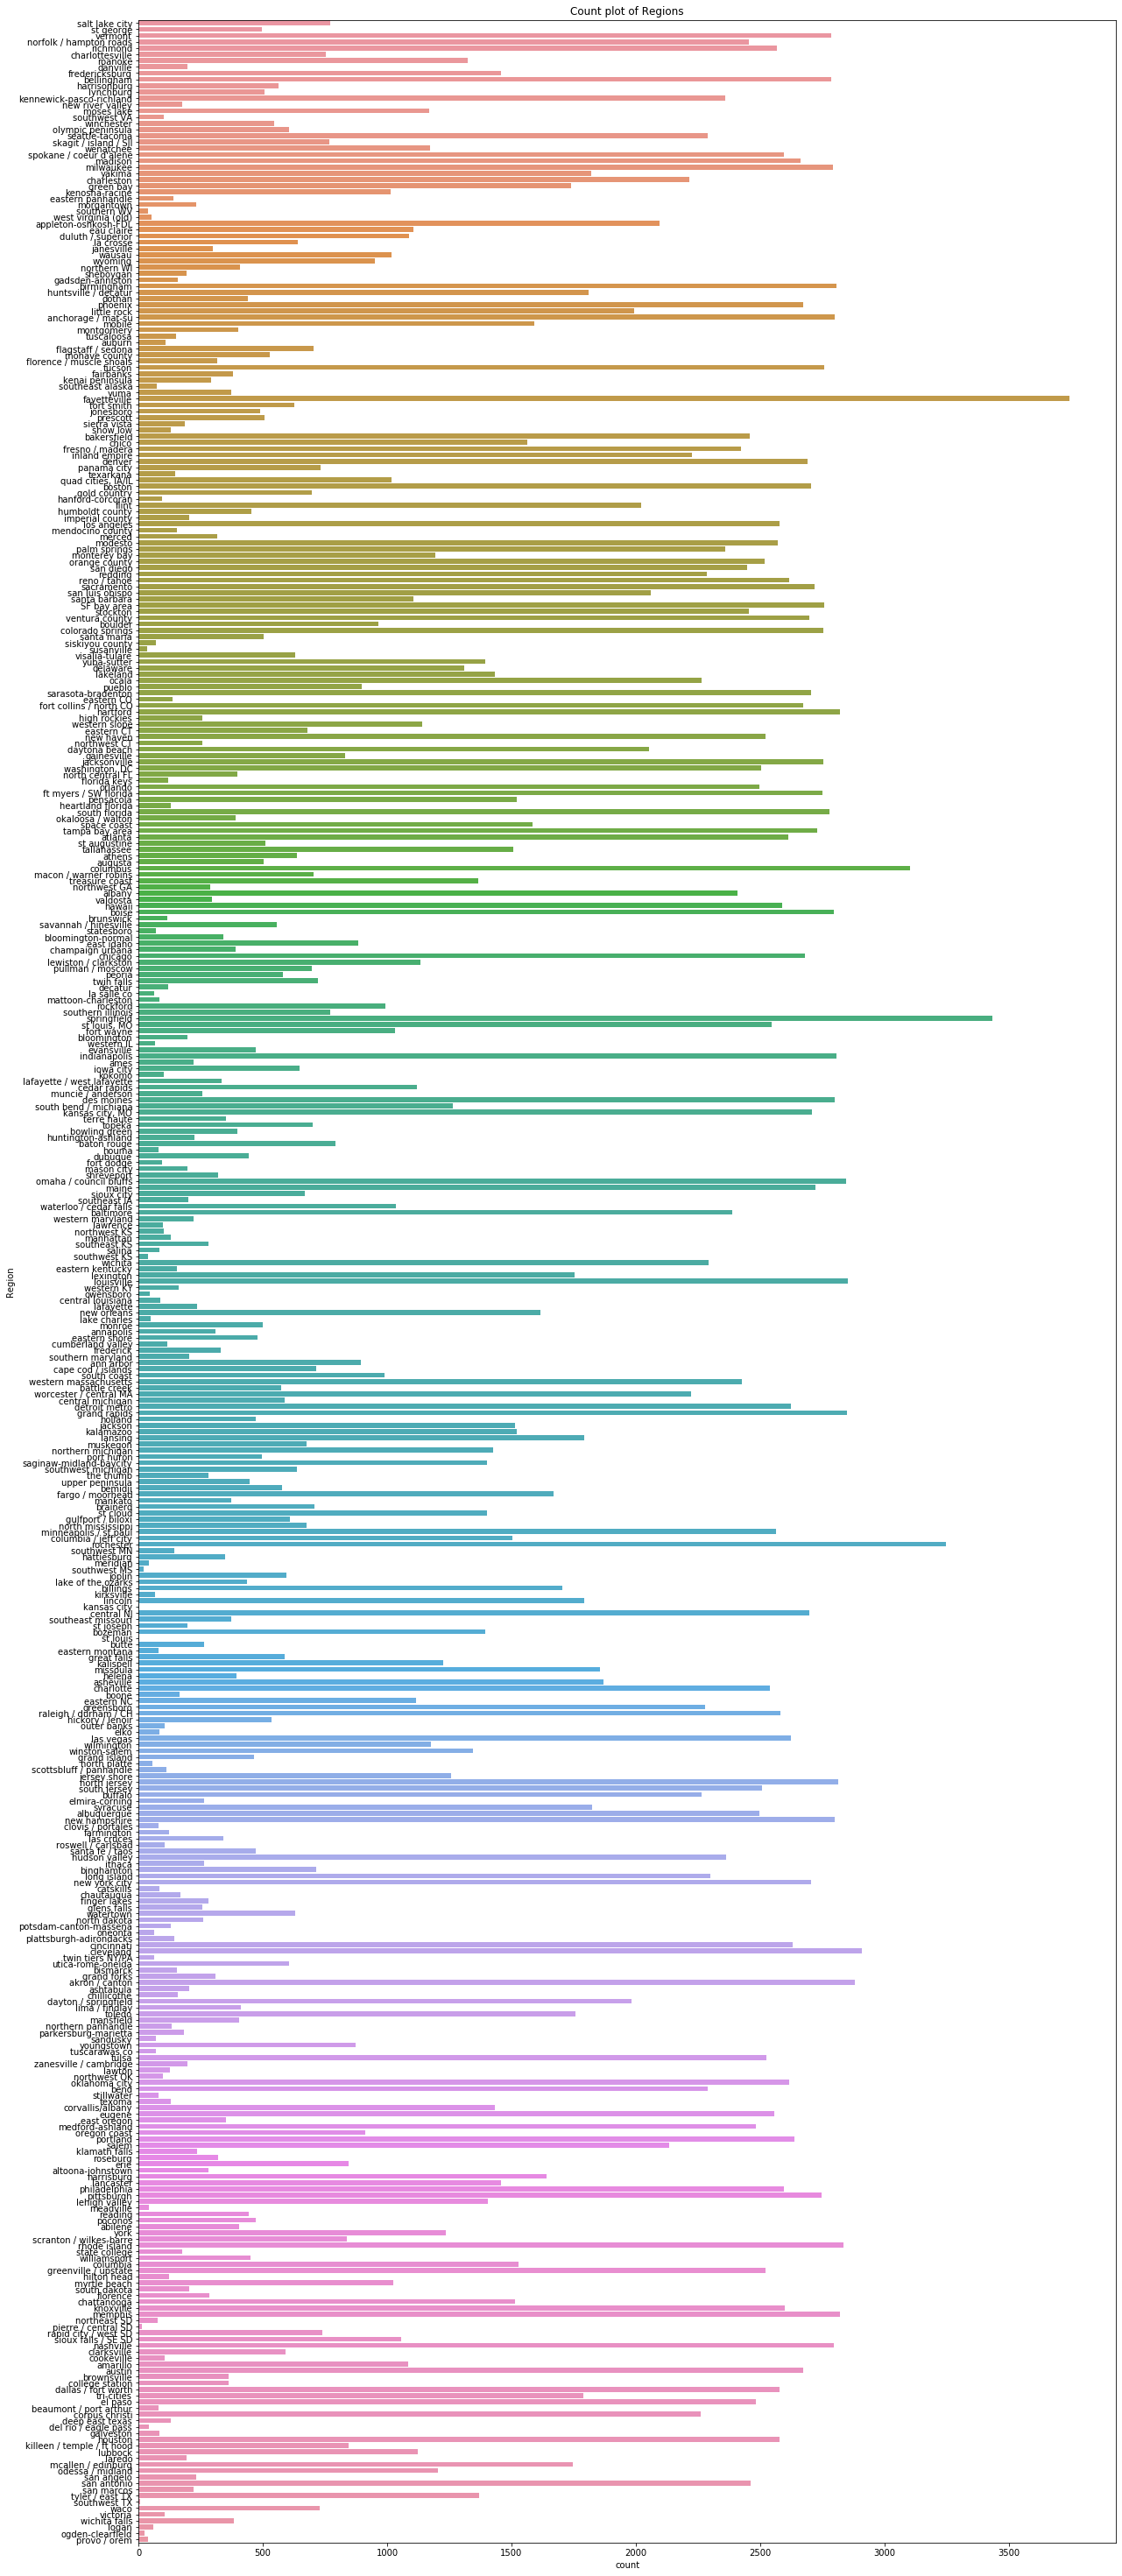

In [19]:
plt.figure(figsize = (20,53))
region_count_plot = sns.countplot(data = new_data, y = "region")
plt.ylabel("Region")
plt.title("Count plot of Regions")
plt.show()

#### The number of Region URLs is very very close to the number of regions, so we think that it could highly correlated with each other. In this case we choose to drop this variable. 

In [20]:
np.unique(new_data['region_url']).shape

(413,)

In [21]:
np.unique(new_data['region']).shape

(403,)

In [22]:
new_data = new_data.drop('region_url', axis = 1)

### Year 
#### When we look at the feature "year", it appears to be numerical and ascending, so it should be included. Also, we need to shrink data regarding this feature, because some observations appear to be unreasonably old. 

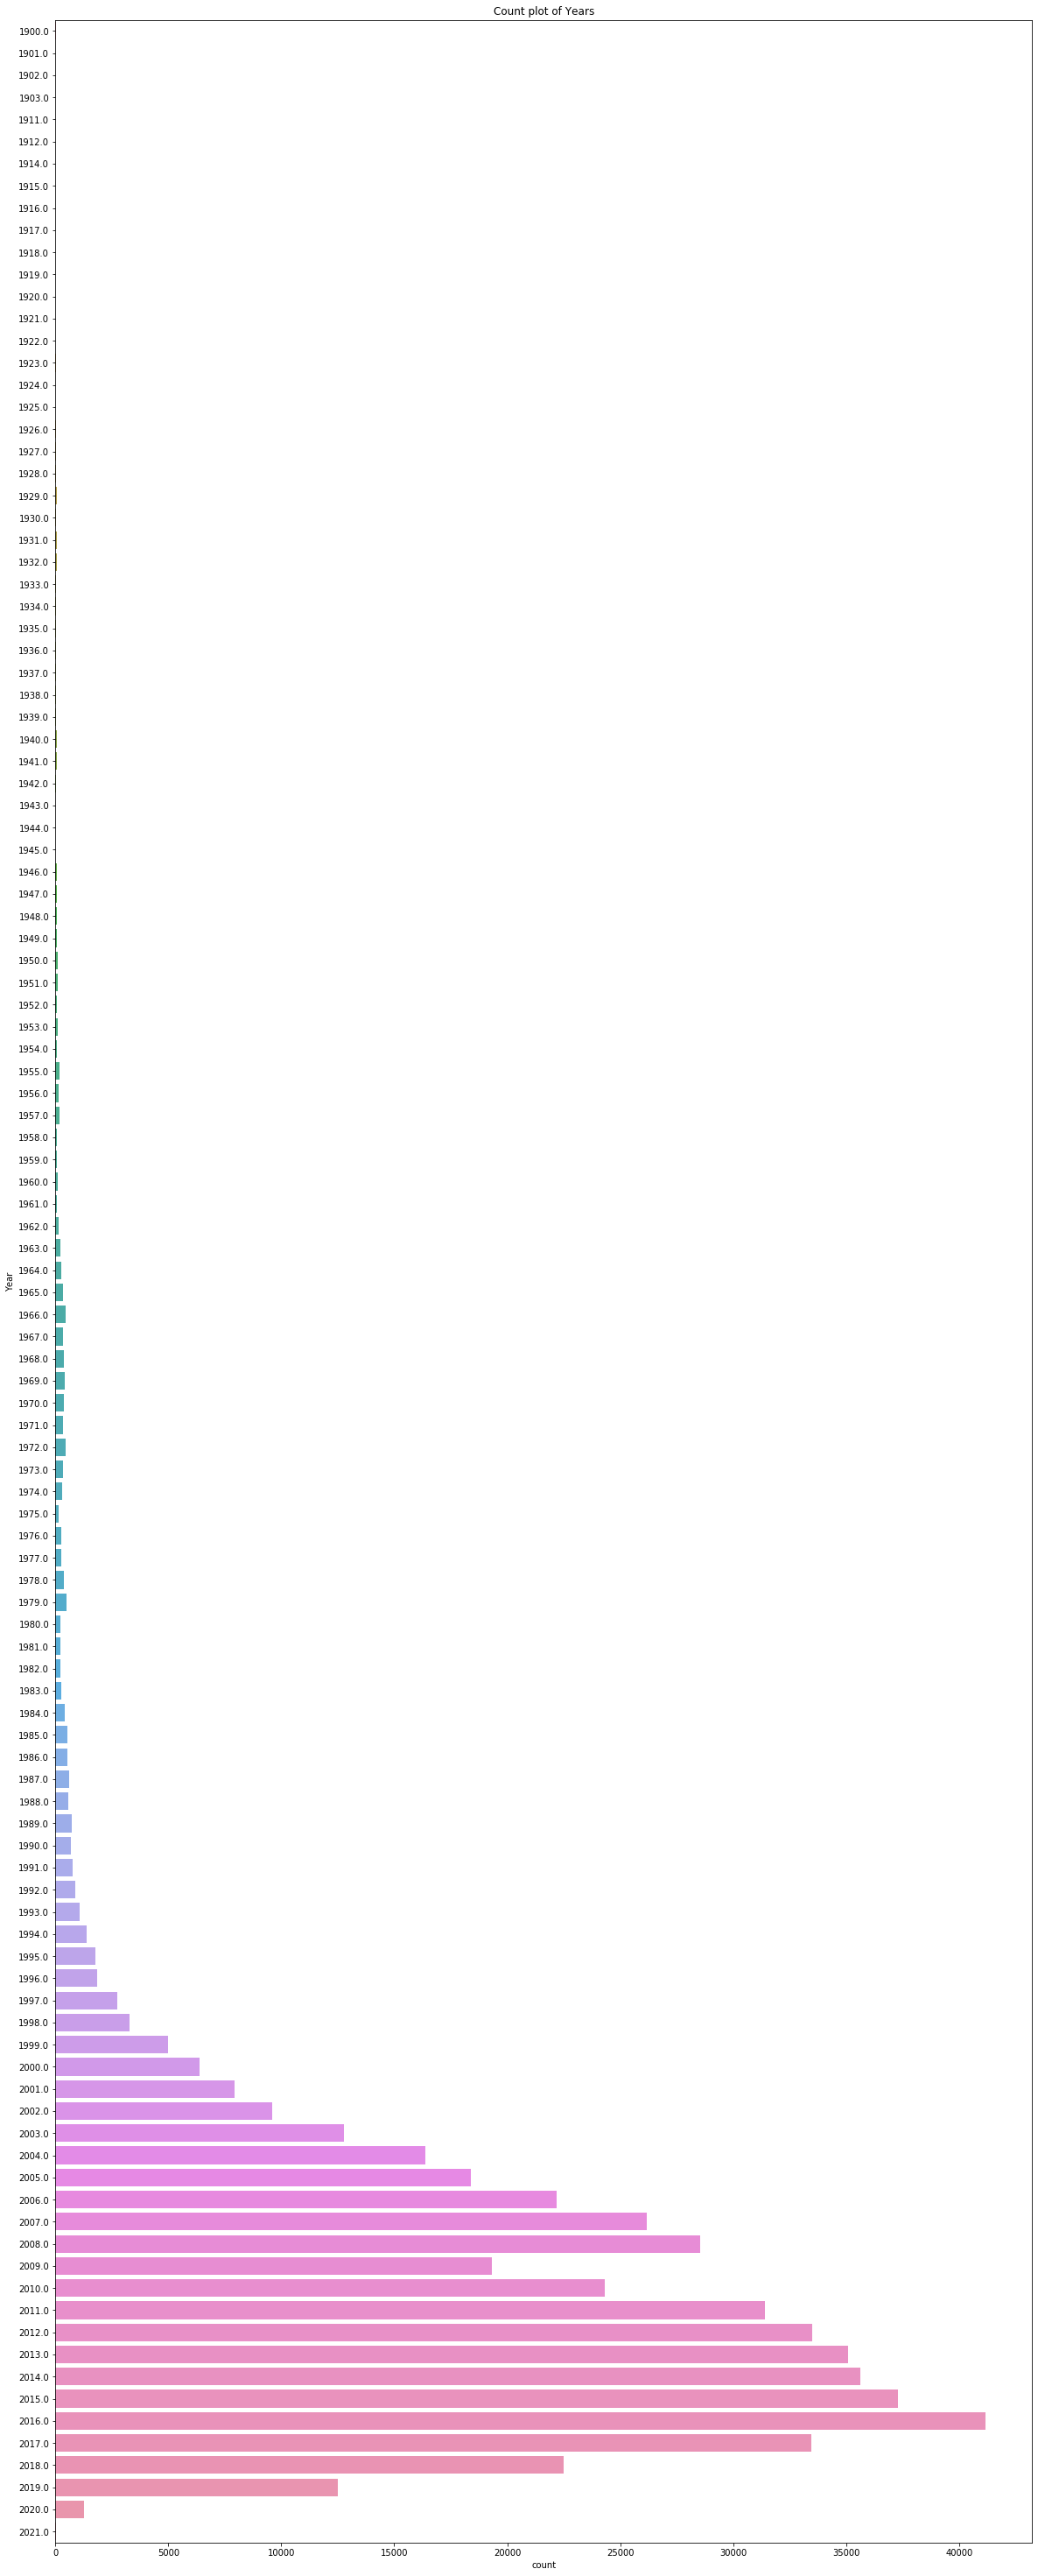

In [23]:
plt.figure(figsize = (20,53))
year_count_plot = sns.countplot(data = data, y = "year")
plt.ylabel("Year")
plt.title("Count plot of Years")
plt.show()

In [24]:
year_Q1 = new_data['year'].quantile(0.25)
year_Q3 = new_data['year'].quantile(0.75)
year_IQR = year_Q3 - year_Q1
new_data = new_data.loc[(new_data['year'] > year_Q1 - 1.5*year_IQR) & (new_data['year'] < year_Q3 + 1.5*year_IQR)]

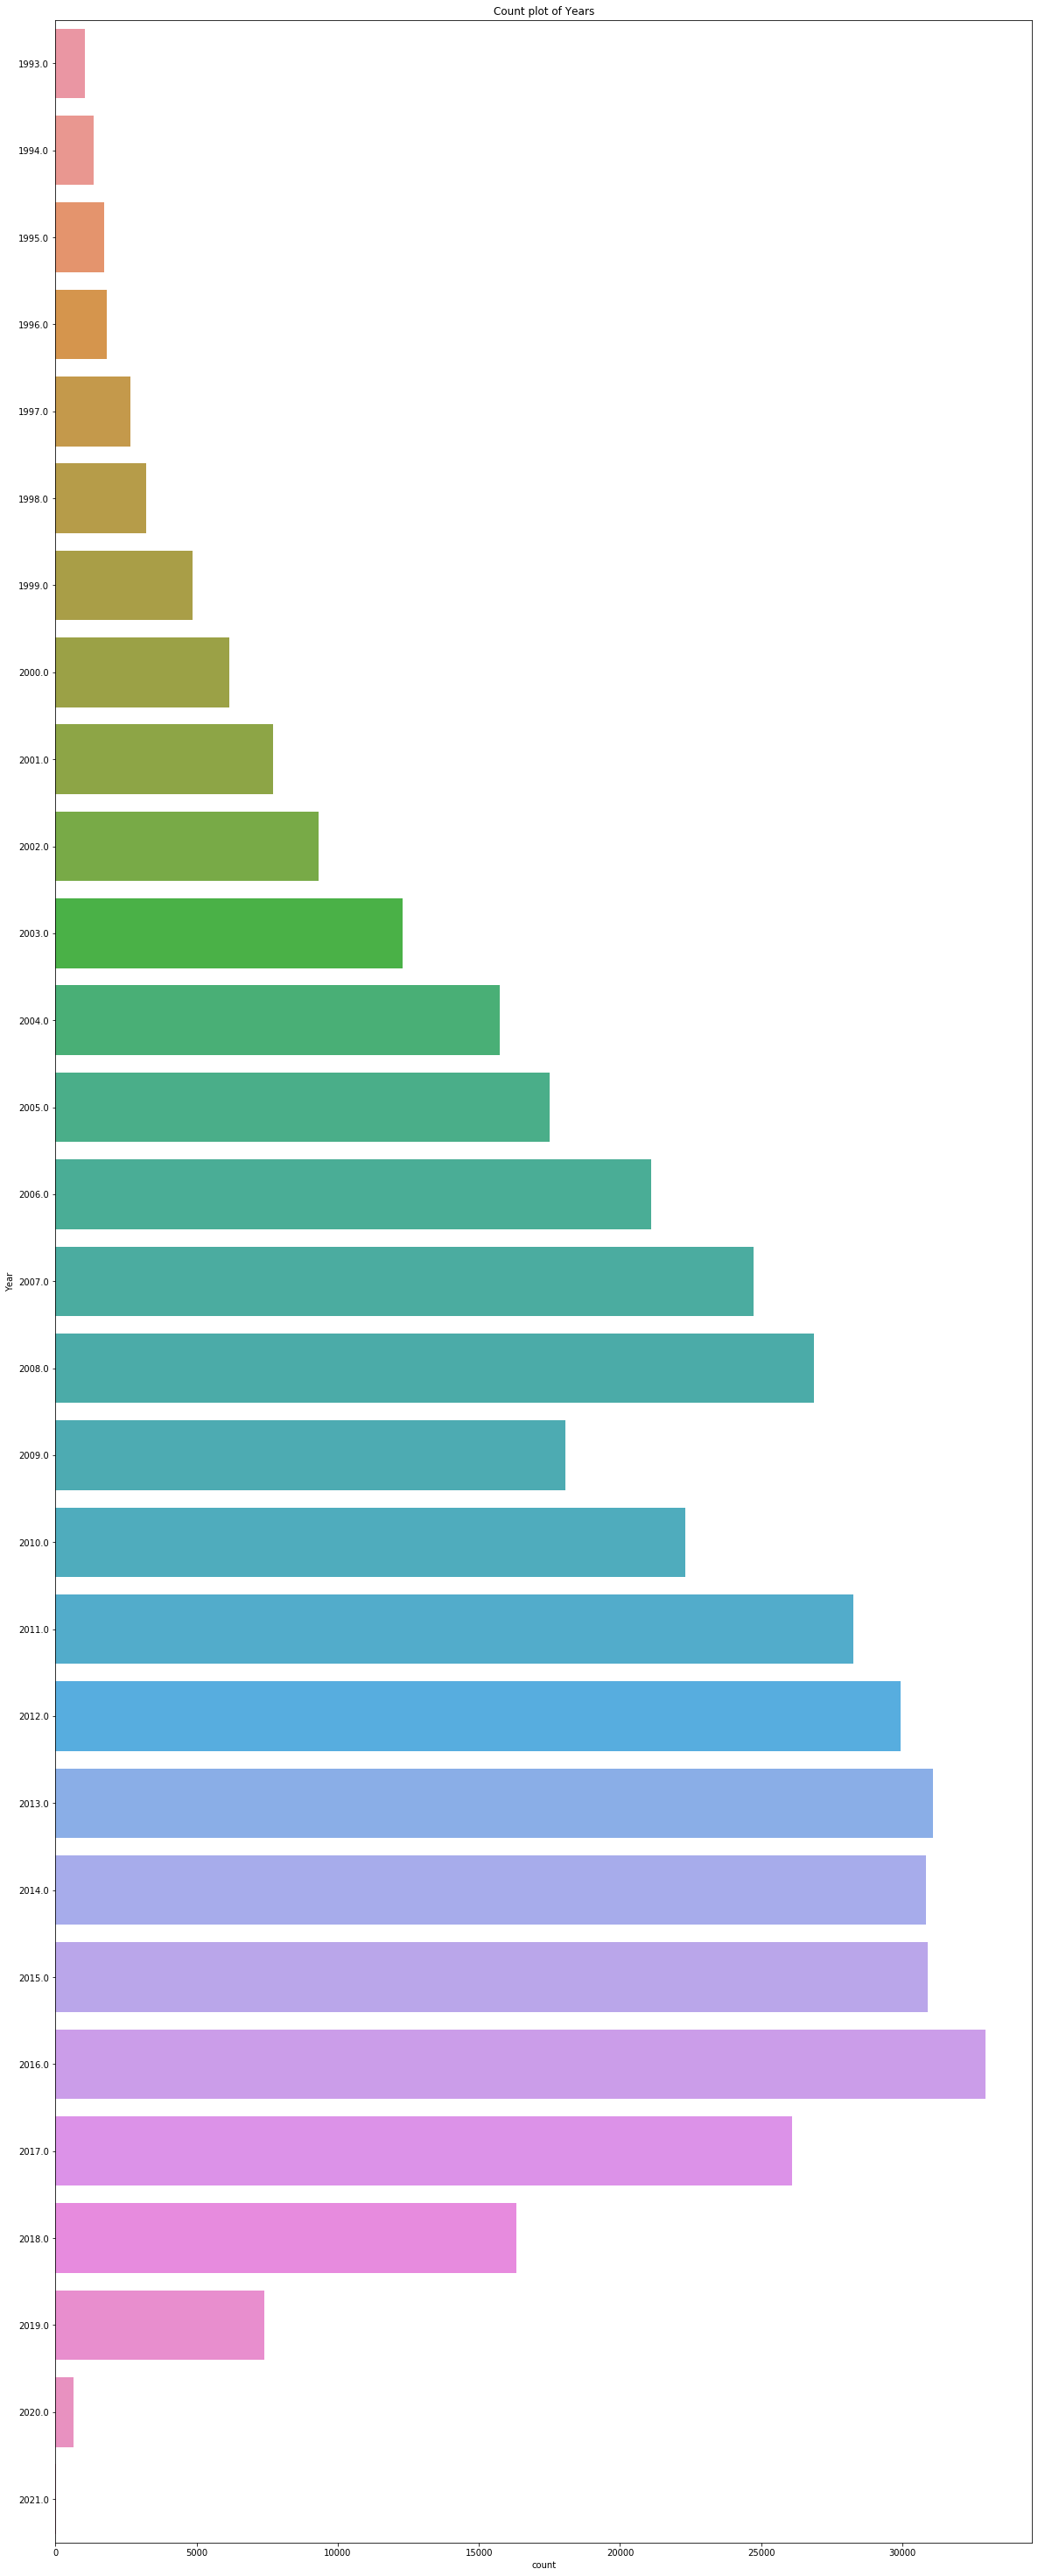

In [25]:
plt.figure(figsize = (20,53))
year_count_plot = sns.countplot(data = new_data, y = "year")
plt.ylabel("Year")
plt.title("Count plot of Years")
plt.show()

### Manufacturer
#### Manufacturer is a categorical feature that can be kept. 

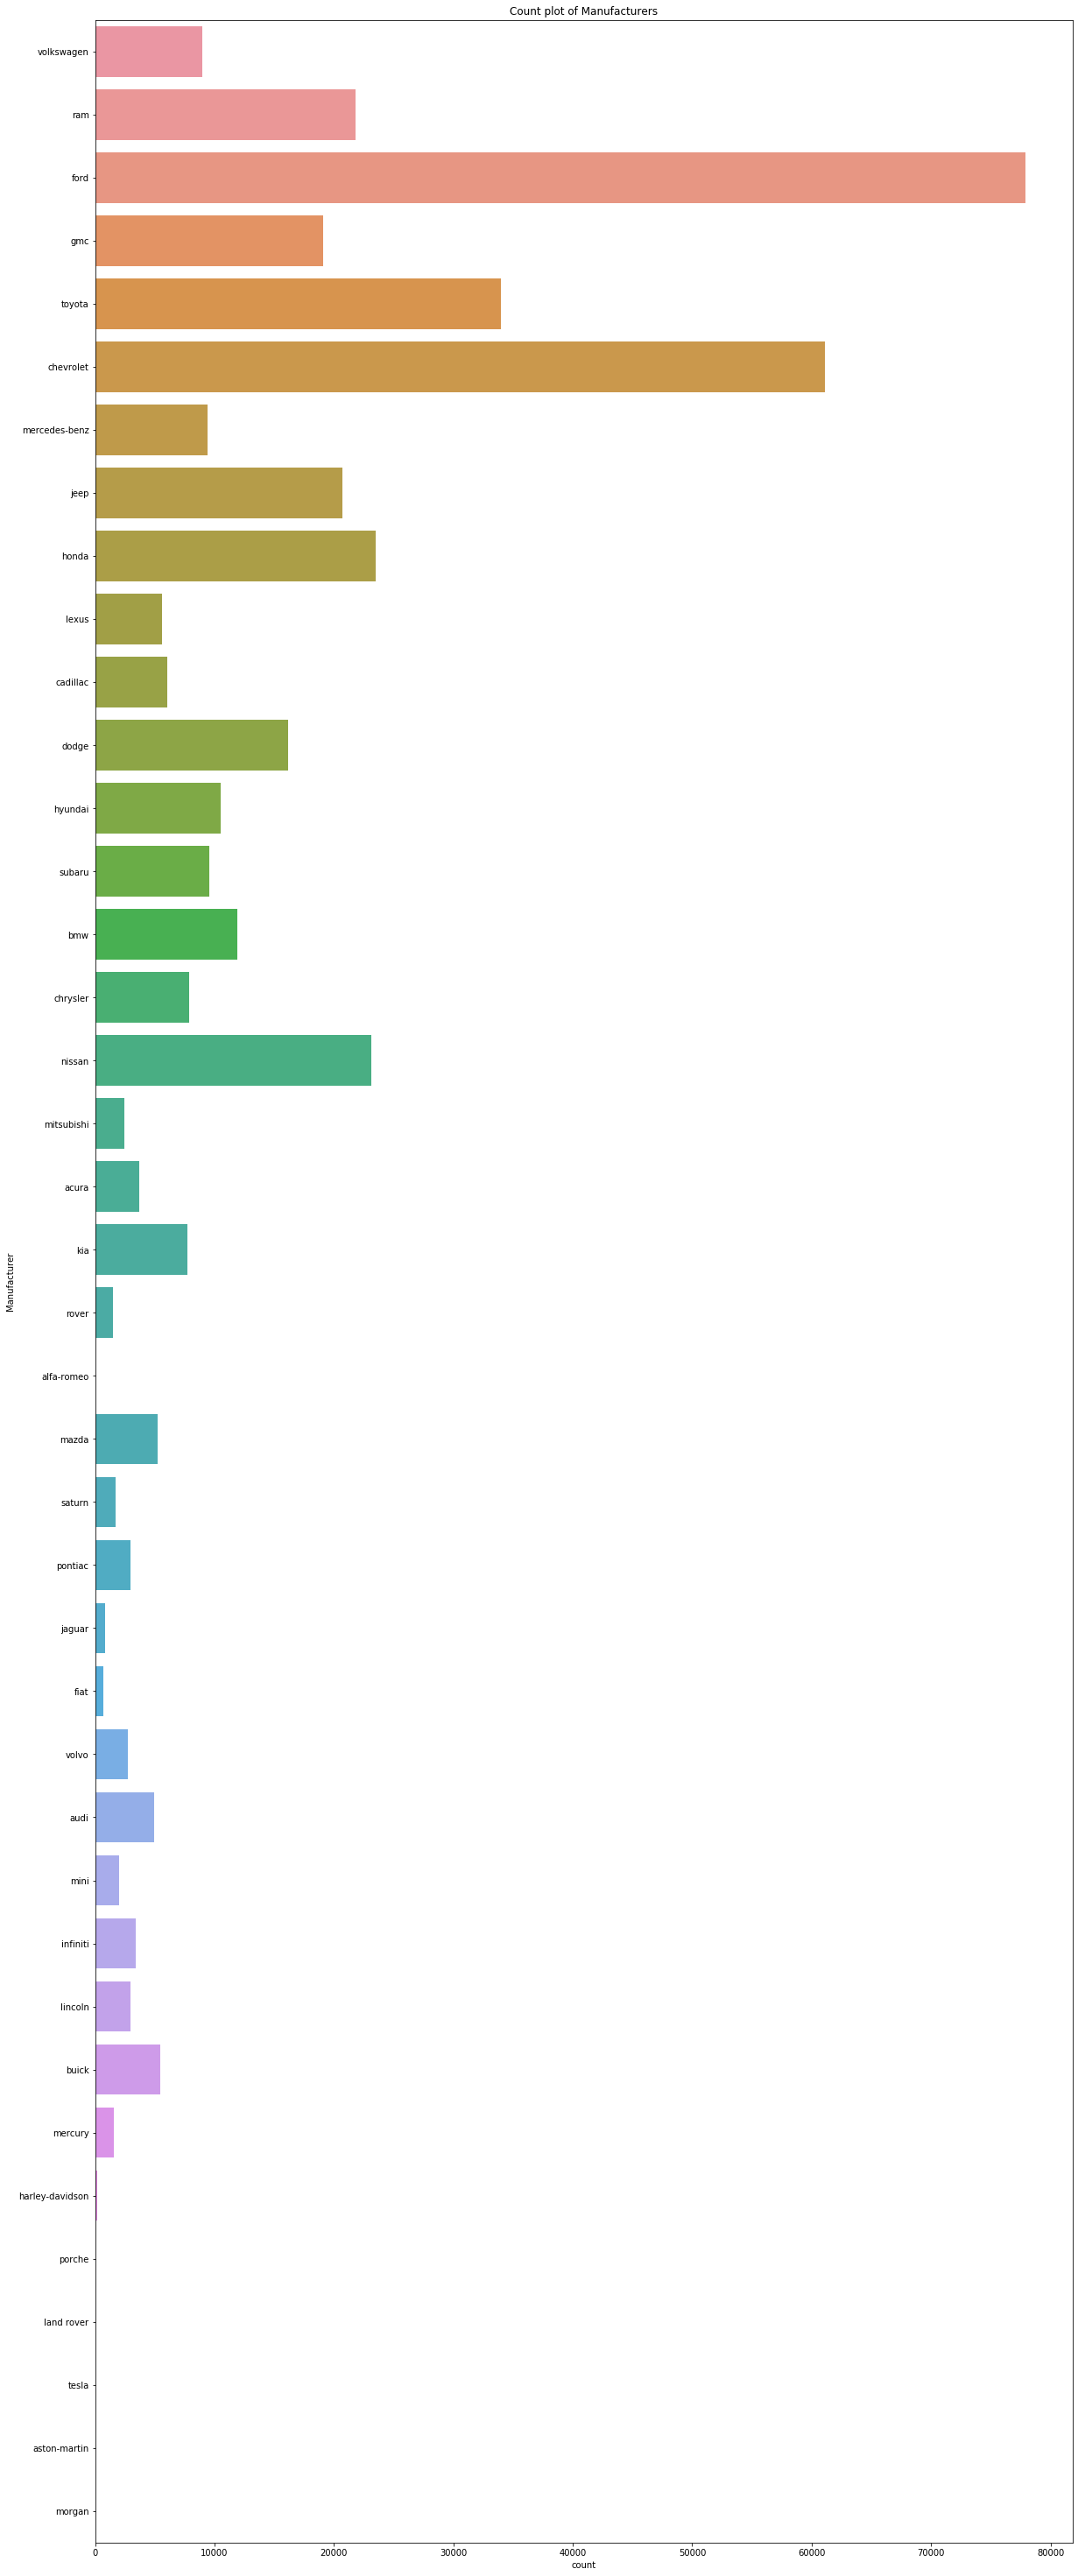

In [26]:
plt.figure(figsize = (20,53))
region_count_plot = sns.countplot(data = new_data, y = "manufacturer")
plt.ylabel("Manufacturer")
plt.title("Count plot of Manufacturers")
plt.show()

#### Model  
There are total of 32834 models in this data set. Some models have a lot of observations, while others only have 1 or 2. We will keep this as a category for now, and consider about interactions later.

In [27]:
new_data['model'].value_counts()

f-150                9820
silverado 1500       6291
1500                 6202
silverado            4548
accord               3549
                     ... 
1997 Chevy.             1
HYNDAI ACCENT GLS       1
tucson v6 awd           1
dakota base             1
535xi turbo             1
Name: model, Length: 29604, dtype: int64

In [28]:
new_data['model'].value_counts().count()

29604

#### Condition can be kept as a categorical variable, and use one-hot encoder to impute. 

In [29]:
new_data['condition'].value_counts()

excellent    122348
good          89030
like new      24542
fair           7874
new             854
salvage         561
Name: condition, dtype: int64

#### Cylinders can also be kept as a categorical variable, and use one-hot encoder to impute.

In [30]:
new_data['cylinders'].value_counts()

6 cylinders     98324
4 cylinders     84828
8 cylinders     76803
5 cylinders      2577
10 cylinders     1561
other             990
3 cylinders       457
12 cylinders       74
Name: cylinders, dtype: int64

#### Fuel

In [31]:
new_data['fuel'].value_counts()

gas         381179
diesel       31753
other        12821
hybrid        3623
electric       559
Name: fuel, dtype: int64

#### Odometer

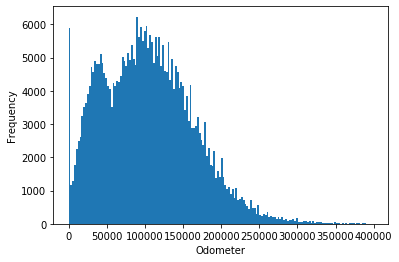

In [32]:
plt.hist(new_data[(new_data['odometer'] > 0) & (new_data['odometer'] < 4 * 1e5)]['odometer'], bins = "auto")
plt.xlabel("Odometer")
plt.ylabel("Frequency")
plt.show()

#### Title Status

In [33]:
new_data['title_status'].value_counts()

clean         412425
rebuilt        10071
salvage         5111
lien            2553
missing          205
parts only       117
Name: title_status, dtype: int64

#### Transmission

In [34]:
new_data['transmission'].value_counts()

automatic    392417
manual        25763
other         11680
Name: transmission, dtype: int64

#### Vin
There are lots of missing values in the "vin" column, plus there are also a lot of unique vin (as it should be), so there is potential leaking information if we use this column.

In [35]:
new_data['vin'].unique().shape

(153982,)

In [36]:
new_data = new_data.drop('vin', axis=1)

#### Drive

In [37]:
new_data['drive'].value_counts()

4wd    143951
fwd    113306
rwd     54201
Name: drive, dtype: int64

#### Size
There are only 167574 observations with size not missing. So we consider use only the type column, since they should be highly correlated. 

In [38]:
new_data['size'].value_counts()

full-size      78246
mid-size       41864
compact        21308
sub-compact     3370
Name: size, dtype: int64

In [39]:
new_data = new_data.drop('size', axis=1)

#### Type
As a categorical feature

In [40]:
new_data['type'].value_counts()

sedan          81918
SUV            80542
pickup         41719
truck          40044
coupe          14610
hatchback      11483
other          10777
wagon           9932
van             9188
mini-van        6689
convertible     5895
bus              559
offroad          542
Name: type, dtype: int64

#### Paint Color
As a categorical feature.
One hot encoder can be used.

In [41]:
new_data['paint_color'].value_counts()

white     75715
black     59766
silver    45665
blue      29909
grey      29320
red       29101
green      8036
custom     7827
brown      6691
yellow     1986
orange     1644
purple      713
Name: paint_color, dtype: int64

#### Image URL and Description
Using both of them will cause leaking information, because there are too much of them. 

In [42]:
new_data['image_url'].value_counts()

https://images.craigslist.org/00i0i_ChcqziILO2_600x450.jpg     167
https://images.craigslist.org/00c0c_hHuL9bNLUgi_600x450.jpg     90
https://images.craigslist.org/00j0j_gg93xlqFjZa_600x450.jpg     88
https://images.craigslist.org/00K0K_2YZAmxs2tOd_600x450.jpg     60
https://images.craigslist.org/01010_b7B8ENzEW2B_600x450.jpg     51
                                                              ... 
https://images.craigslist.org/00G0G_fY9ZYs3SuOf_600x450.jpg      1
https://images.craigslist.org/00v0v_8dSL9L2PbI1_600x450.jpg      1
https://images.craigslist.org/00P0P_fV5Vs9OuZ9t_600x450.jpg      1
https://images.craigslist.org/00P0P_4yxvfA9eM89_600x450.jpg      1
https://images.craigslist.org/01313_edSp6gywk5U_600x450.jpg      1
Name: image_url, Length: 302174, dtype: int64

In [43]:
new_data = new_data.drop(['image_url', 'description'], axis = 1)

#### State
As a categorical feature. 

In [44]:
new_data['state'].value_counts()

ca    43554
fl    29600
tx    24900
ny    19425
mi    19097
oh    17225
or    14790
nc    14578
pa    14132
wi    13775
wa    12671
tn    12243
co    11133
il    10228
va    10142
ia    10043
mn     9105
nj     9015
ma     8847
id     8607
al     7460
az     7315
mt     7234
sc     7083
in     6713
ks     6199
ct     6096
ga     5861
mo     5596
ar     5425
ok     5401
ky     5338
md     3829
ak     3475
nm     3356
la     3326
ri     2785
nh     2756
vt     2751
me     2673
nv     2560
hi     2543
dc     2446
ne     2346
ms     2190
sd     2038
ut     1309
de     1259
wy      914
wv      777
nd      709
Name: state, dtype: int64

#### Longitutde and latitude
It seems like longitude and latitude has nothing to do with the price directly. 
However, we can combine those two features into one single feature, which is the harvesine distance.

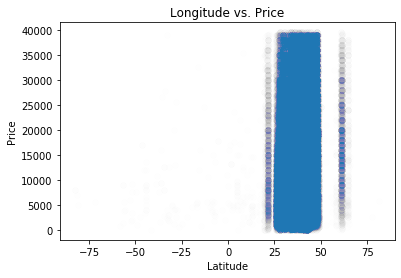

In [45]:
plt.plot(new_data['lat'], new_data['price'],'o', alpha = 0.005)
plt.xlabel("Latitude")
plt.ylabel("Price")
plt.title("Longitude vs. Price")
plt.show()

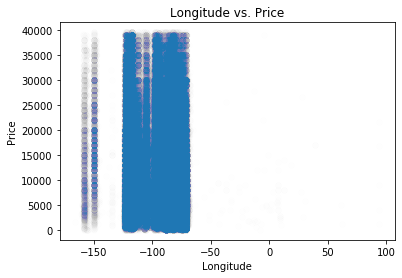

In [46]:
plt.plot(new_data['long'], new_data['price'],'o', alpha = 0.005)
plt.xlabel("Longitude")
plt.ylabel("Price")
plt.title("Longitude vs. Price")
plt.show()

In [47]:
from math import radians, cos, sin, asin, sqrt
def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

In [48]:
new_data['harvesine_distance'] = [single_pt_haversine(x, y) for x, y in zip(new_data.long, new_data.lat)]

In [49]:
new_data.index = np.arange(0, len(new_data))

In [50]:
new_data.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,harvesine_distance
0,salt lake city,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,clean,manual,4wd,hatchback,black,ut,40.7372,-111.858,11829.546278
1,salt lake city,13999,2009.0,ram,NaN,NaN,NaN,gas,120057.0,clean,automatic,4wd,pickup,silver,ut,40.3744,-104.694,11246.486701
2,salt lake city,34500,2017.0,ford,f-350,NaN,NaN,diesel,95484.0,clean,automatic,4wd,pickup,white,ut,40.3744,-104.694,11246.486701
3,salt lake city,14500,2007.0,gmc,sierra,NaN,NaN,gas,89340.0,clean,automatic,4wd,pickup,NaN,ut,40.3744,-104.694,11246.486701
4,salt lake city,12500,2013.0,ford,f-250,NaN,NaN,gas,226031.0,clean,automatic,4wd,pickup,white,ut,40.3744,-104.694,11246.486701


In [51]:
new_data = new_data.drop(['long', 'lat'], axis = 1)

## Task 2

In [75]:
import random
random.seed(5)

In [76]:
sample = new_data.sample(n = 5000)

In [77]:
sample.dtypes

region                 object
price                   int64
year                  float64
manufacturer           object
model                  object
condition              object
cylinders              object
fuel                   object
odometer              float64
title_status           object
transmission           object
drive                  object
type                   object
paint_color            object
state                  object
harvesine_distance    float64
dtype: object

#### Now there are total of 20 features that we plan to use for the training the model. 

In [78]:
X = sample.drop('price', axis = 1)
y = sample['price']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [80]:
numerical = X_train.dtypes == "float64"
one_hot = X_train.dtypes == "object"

In [81]:
one_hot.region = False
one_hot.region_url = False
one_hot.manufacturer = False
one_hot.model = False

In [82]:
target = ~one_hot
target.year = False
target.odometer = False
target.harvesine_distance = False

In [83]:
preprocess = make_column_transformer((make_pipeline(SimpleImputer(strategy="median"),
                                                    StandardScaler()), numerical),
                                     (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                    OneHotEncoder(handle_unknown="ignore")), one_hot),
                                     (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                    TargetEncoder()), target)
                                    )

In [84]:
LinearR_model = make_pipeline(preprocess, LinearRegression())

In [85]:
LinearR_score = cross_val_score(LinearR_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(LinearR_score))

0.5789911053059605


In [86]:
Ridge_model = make_pipeline(preprocess, Ridge())
Ridge_score = cross_val_score(Ridge_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(Ridge_score))

0.1460345636145977


In [87]:
Lasso_model = make_pipeline(preprocess, Lasso(max_iter = 5000, tol = 0.5))
Lasso_score = cross_val_score(Lasso_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(Lasso_score))

0.5873784975797607


## Task 3

#### We can see that the relationship between year and price is not very linear. Adding polynomial feature might help in this case. 

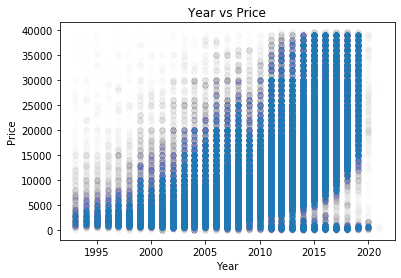

In [88]:
plt.plot(new_data['year'], new_data['price'], 'o', alpha = 0.0019609)
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Year vs Price")
plt.show()

In [89]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432873 entries, 0 to 432872
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   region              432873 non-null  object 
 1   price               432873 non-null  int64  
 2   year                432873 non-null  float64
 3   manufacturer        417662 non-null  object 
 4   model               427069 non-null  object 
 5   condition           245209 non-null  object 
 6   cylinders           265614 non-null  object 
 7   fuel                429935 non-null  object 
 8   odometer            360370 non-null  float64
 9   title_status        430482 non-null  object 
 10  transmission        429860 non-null  object 
 11  drive               311458 non-null  object 
 12  type                313898 non-null  object 
 13  paint_color         296373 non-null  object 
 14  state               432873 non-null  object 
 15  harvesine_distance  427704 non-nul

#### Using min max scaler even lower the result.

In [90]:
# Change to Min_Max Scaler
preprocess_2 = make_column_transformer((make_pipeline(SimpleImputer(strategy="median"),
                                                    MinMaxScaler()), numerical),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                    OneHotEncoder(handle_unknown="ignore")), one_hot),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                    TargetEncoder()), target)
                                      )
LinearR_model_2 = make_pipeline(preprocess_2, LinearRegression())
LinearR_score_2 = cross_val_score(LinearR_model_2, X_train, np.ravel(y_train), cv = 5)
print(np.mean(LinearR_score_2))

0.5791031942544469


#### Using KNN imputation doesn't improve the result.

In [91]:
# Change numerical missing values to KNNImputer
preprocess_3 = make_column_transformer((make_pipeline(KNNImputer(),
                                                    StandardScaler()), numerical),
                                       (make_pipeline(SimpleImputer(strategy = "most_frequent"),
                                                    OneHotEncoder(handle_unknown="ignore")), one_hot),
                                       (make_pipeline(SimpleImputer(strategy = "most_frequent"),
                                                    TargetEncoder()), target)
                                      )
LinearR_model_3 = make_pipeline(preprocess_3, LinearRegression())
LinearR_score_3 = cross_val_score(LinearR_model_3, X_train, np.ravel(y_train), cv = 5)
print(np.mean(LinearR_score_3))

0.5790183037295827


#### Make the numerical features polynomial 2 improves the score. 

In [92]:
# Polynomial Feature
preprocess_4 = make_column_transformer((make_pipeline(SimpleImputer(strategy="median"), StandardScaler(), 
                                                      PolynomialFeatures(2)), numerical),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                    OneHotEncoder(handle_unknown="ignore")), one_hot),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                    TargetEncoder()), target)
                                       )
LinearR_model_4 = make_pipeline(preprocess_4, LinearRegression())
LinearR_score_4 = cross_val_score(LinearR_model_4, X_train, np.ravel(y_train), cv = 5)
print(np.mean(LinearR_score_4))

0.5668975357264053


In [93]:
preprocess_5 = make_column_transformer((make_pipeline(SimpleImputer(strategy="median"), StandardScaler(), 
                                                      PolynomialFeatures(3)), numerical),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                      OneHotEncoder(handle_unknown="ignore")), one_hot),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                      TargetEncoder()), target)
                                       )
LinearR_model_5 = make_pipeline(preprocess_5, LinearRegression())
LinearR_score_5 = cross_val_score(LinearR_model_5, X_train, np.ravel(y_train), cv = 5)
print(np.mean(LinearR_score_5))

0.4755150180870082


In [94]:
Lasso_model = make_pipeline(preprocess_4, Lasso(max_iter = 5000, tol = 0.5))
Lasso_score = cross_val_score(Lasso_model, X_train, np.ravel(y_train), cv = 5)
print(np.mean(Lasso_score))

0.600337986261228


## Task 4

In [95]:
RF_model = make_pipeline(preprocess_3, RandomForestRegressor())
RF_param_dist = {"randomforestregressor__max_depth": [3, None],
                 "randomforestregressor__max_features": randint(1, 20),
                 "randomforestregressor__min_samples_split": randint(2, 11),
                 "randomforestregressor__bootstrap": [True, False]
                 }
random_search = RandomizedSearchCV(RF_model,
                                   param_distributions=RF_param_dist,
                                   n_iter=50)

In [96]:
random_search = random_search.fit(X_train, np.ravel(y_train))

In [97]:
random_search.score(X_test, np.ravel(y_test))

0.6908966969949137

In [98]:
Lasso_model = make_pipeline(preprocess_4, Lasso(max_iter = 5000, tol = 0.5))
Lasso_param_dit = {"lasso__alpha": np.logspace(-4,5,20)}
random_search_Lasso = RandomizedSearchCV(Lasso_model,
                                         Lasso_param_dit,
                                         n_iter = 20)

In [99]:
random_search_Lasso.fit(X_train, np.ravel(y_train))

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('simpleimputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                

In [100]:
random_search_Lasso.score(X_test,np.ravel(y_test))

0.6383888208610795

In [106]:
# XGBRegressor base model:
xgb1 = make_pipeline(preprocess_3, 
                     XGBRegressor(
                         learning_rate =0.1,
                         n_estimators=1000,
                         max_depth=5,
                         min_child_weight=1,
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective ='reg:squarederror',
                         seed=6
                     ))
xgb1_score = cross_val_score(xgb1, X_train, np.ravel(y_train), cv = 5)
print(np.mean(xgb1_score))

0.6927092139385994


In [111]:
# Tune on max_depth and min_child_weight
xgb2 = make_pipeline(preprocess_3,
                     XGBRegressor(
                         learning_rate =0.1,
                         n_estimators=1000,
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective ='reg:squarederror',
                         seed=16
                     ))
xgb2_param_dict = {
    'xgbregressor__max_depth': range(3, 10, 2),
    'xgbregressor__min_child_weight': range(1, 6, 2)
}

xgb2_gridsearchcv = GridSearchCV(xgb2, param_grid = xgb2_param_dict, cv = 5)
xgb2_gridsearchcv.fit(X_train, np.ravel(y_train))

print('Best Params for XGBRegressor:',xgb2_gridsearchcv.best_params_)
print('Best Score for XGBRegressor:',xgb2_gridsearchcv.best_score_ )

Best Params for XGBRegressor: {'xgbregressor__max_depth': 3, 'xgbregressor__min_child_weight': 3}
Best Score for XGBRegressor: 0.6955125262729415


In [113]:
xgb3 = make_pipeline(preprocess_3,
                     XGBRegressor(
                         learning_rate =0.1,
                         n_estimators=1000,
                         max_depth=3,
                         min_child_weight=3,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective ='reg:squarederror',
                         seed=16
                     ))
xgb3_param_dict = {
    'xgbregressor__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

xgb3_gridsearchcv = GridSearchCV(xgb3, param_grid = xgb3_param_dict, cv = 5)
xgb3_gridsearchcv.fit(X_train, np.ravel(y_train))

print('Best Params for XGBRegressor:',xgb3_gridsearchcv.best_params_)
print('Best Score for XGBRegressor:',xgb3_gridsearchcv.best_score_ )

Best Params for XGBRegressor: {'xgbregressor__gamma': 0}
Best Score for XGBRegressor: 0.6955125262729415


In [120]:
# Tune on subsample and colsample_bytree
xgb4 = make_pipeline(preprocess_3,
                     XGBRegressor(
                         learning_rate =0.1,
                         n_estimators=1000,
                         max_depth=3,
                         min_child_weight=3,
                         gamma=0,
                         objective ='reg:squarederror',
                         seed=16
                     ))
xgb4_param_dict = {
    'xgbregressor__subsample': [0.8, 0.85, 0.9],
    'xgbregressor__colsample_bytree': [0.5, 0.55, 0.6, 0.65],
}

xgb4_gridsearchcv = GridSearchCV(xgb4, param_grid = xgb4_param_dict, cv = 5)
xgb4_gridsearchcv.fit(X_train, np.ravel(y_train))

print('Best Params for XGBRegressor:',xgb4_gridsearchcv.best_params_)
print('Best Score for XGBRegressor:',xgb4_gridsearchcv.best_score_ )

Best Params for XGBRegressor: {'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__subsample': 0.85}
Best Score for XGBRegressor: 0.6994099029569734


In [125]:
# Lower Learning Rate
xgb5 = make_pipeline(preprocess_3,
                     XGBRegressor(
                         learning_rate =0.01,
                         n_estimators=10000,
                         max_depth=3,
                         min_child_weight=3,
                         gamma=0,
                         subsample=0.85,
                         colsample_bytree=0.6,
                         objective ='reg:squarederror',
                         seed=16
                     ))

xgb5_score = cross_val_score(xgb5, X_train, np.ravel(y_train), cv = 5)
print(np.mean(xgb5_score))

0.700450465090684


In [240]:
from sklearn.inspection import permutation_importance
xgb5.fit(X_train, np.ravel(y_train))

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('knnimputer',
                                                                   KNNImputer(add_indicator=False,
                                                                              copy=True,
                                                                              metric='nan_euclidean',
                                                                              missing_values=nan,
                                                                              n_neighbors=5,
                                                          

In [144]:
result = permutation_importance(xgb5, X_train, y_train, n_repeats=10,
                                random_state=42)


In [285]:
numerical_features = ['year', 'odometer', 'harvesine_distance']
target_features = ['region', 'manufacturer', 'model']
one_hot_features = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 
                    'type', 'paint_color', 'state']
one_hot_feature_names = list(xgb5.steps[0][1].transformers_[1][1].steps[1][1].get_feature_names(one_hot_features))
feature_names = ['year', 'odometer', 'harvesine_distance'] + \
                 one_hot_feature_names + ['region', 'manufacturer', 'model']

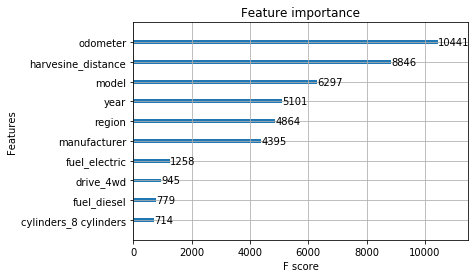

In [284]:
from xgboost import plot_importance
xgb5.steps[1][1].get_booster().feature_names = feature_names
plot_importance(xgb5.steps[1][1], max_num_features=10)
plt.show()

In [298]:
data_items = xgb5.steps[1][1].get_booster().get_score().items()
data_list = list(data_items)

df = pd.DataFrame(data_list)
df.sort_values(by = 1).head(n = 50)

,0,1
107,state_nm,6
66,state_ri,8
108,state_vt,9
105,state_sd,14
106,paint_color_purple,15
96,paint_color_yellow,16
72,state_md,19
101,state_wy,19
99,state_ma,32
82,state_ok,35


From this, we know that we can ignore the features state, color, and title status, since the f score for each of its level is relatively small. It might not make my model better, but it will certainly make the model easier to be interpreted. 

#### Task 6

In [307]:
X_train_2 = X_train.drop(['title_status', 'paint_color', 'state'], axis = 1)
X_test_2 = X_test.drop(['title_status', 'paint_color', 'state'], axis = 1)

In [308]:
numerical_2 = X_train_2.dtypes == "float"
one_hot_2 = X_train_2.dtypes == "object"
one_hot_2.model = False
one_hot_2.manufacturer = False
target_2 = ~one_hot_2
target_2.odometer = False
target_2.year = False
target_2.harvesine_distance = True

In [310]:
preprocess_n = make_column_transformer((make_pipeline(SimpleImputer(strategy="median"),
                                                      StandardScaler()), numerical_2),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                      OneHotEncoder(handle_unknown="ignore")), one_hot_2),
                                       (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                                      TargetEncoder()), target_2)
                                      )

In [312]:
LinearR_model_n = make_pipeline(preprocess_n, LinearRegression())
LinearR_score_n = cross_val_score(LinearR_model_n, X_train_2, np.ravel(y_train), cv = 5)
print(np.mean(LinearR_score_n))

0.5577091842500874


In [ ]:
LinearR_model_n = make_pipeline(preprocess_n, )

In [316]:
tree = make_pipeline(preprocess_n, DecisionTreeRegressor(max_leaf_nodes = 10))
tree_score_n = cross_val_score(tree, X_train_2, np.ravel(y_train), cv = 5)
print(np.mean(tree_score_n))

0.5023165713240141


For this dataset, it might be hard to get a very small model to interpret the data. 